# Scooby Evaluator

## General Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
import scipy
import torch
import tqdm
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model

from torch.utils.data import DataLoader

from enformer_pytorch.data import GenomeIntervalDataset

from scooby.modeling import Scooby
from scooby.data import onTheFlyDataset, onTheFlyPseudobulkDataset
from scooby.utils.utils import fix_rev_comp_multiome, undo_squashed_scale, get_pseudobulk_count_pred,get_gene_slice_and_strand

In [3]:
data_path = '/s/project/QNA/scborzoi/submission_data/'

## scooby

### Functions for Pearson correlation

In [4]:
def stack_and_pearson(x,y):
    return torch.corrcoef(torch.stack([x,y]))[0,1]
batched_pearson = torch.vmap(stack_and_pearson, chunk_size=1)

def predict(model, seqs, seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None):
    bs = seqs.shape[0]
    # assert bs == 1
    with torch.no_grad():
        with torch.autocast("cuda"):
            outputs = model.forward_sequence_w_convs(seqs, conv_weights, conv_biases, bins_to_predict = bins_to_predict)
            if bins_to_predict is not None:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = (6143 - bins_to_predict))
            else:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None)
    flipped_version = torch.flip(outputs_rev_comp,(1,-3))
    # outputs_rev_comp_test = fix_rev_comp_multiome(flipped_version) #fix_rev_comp2(flipped_version)
    return (outputs + flipped_version)/2

### Load the model

In [5]:
accelerator = Accelerator(step_scheduler_with_optimizer = False)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


#### Option 1: Load pretrained scooby from the hub

#### Option 2: Load self-trained scooby checkpoint, un-lora it, and save it

In [6]:
import safetensors
from borzoi_pytorch.config_borzoi import BorzoiConfig
from scooby.utils.utils import get_lora
#Initialize the config
config = BorzoiConfig.from_pretrained("johahi/flashzoi-replicate-0")
config.count_mode = "TSS"
csb = Scooby.from_pretrained(
        'johahi/flashzoi-replicate-0',
        config = config,
        cell_emb_dim=14,
        embedding_dim=1920,
        n_tracks=1,
        return_center_bins_only=True,
        disable_cache=False,
        use_transform_borzoi_emb=False,
    )
# we have to make the lora version, load the weights, and merge the lora weights back into scooby
# csb = get_lora(csb, train=False)
print (safetensors.torch.load_model(csb,'/s/project/QNA/borzoi_saved_models/scooby_epoch_70_0_scooby_count_onlyfullFT/model.safetensors')) 
csb = csb.merge_and_unload()

# If you want to save the model to load it quicker next time
# csb.save_pretrained('test_scooby_checkpoint')
# can be then loaded with 
# scooby = Scooby.from_pretrained('test_scooby_checkpoint', cell...)

/opt/modules/i12g/anaconda/envs/scooby_package/lib/python3.9/site-packages/flash_attn/ops/fused_dense.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/opt/modules/i12g/anaconda/envs/scooby_package/lib/python3.9/site-packages/flash_attn/ops/fused_dense.py:71: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output, *args):
/opt/modules/i12g/anaconda/envs/scooby_package/lib/python3.9/site-packages/flash_attn/ops/fused_dense.py:252: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/opt/modules/i12g/anaconda/envs/scooby_package/lib/python3.9/site-packages/flash_attn/ops/fused_dense.py:349: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please 

(set(), [])


AttributeError: 'Scooby' object has no attribute 'merge_and_unload'

### Specify genome

In [7]:
gtf_file = os.path.join(data_path, "gencode.v32.annotation.sorted.gtf.gz")
fasta_file = os.path.join(data_path, 'scooby_training_data/genome_human.fa')
bed_file = os.path.join(data_path, 'scooby_training_data/sequences.bed')

### Load neighbors and embedding

In [8]:
base_path = os.path.join(data_path, 'snapatac', 'pseudobulks_fixed/')

In [9]:
sample = 'merged'
neighbors = scipy.sparse.load_npz(os.path.join(data_path, 'scooby_training_data', 'no_neighbors.npz'))
embedding = pd.read_parquet(os.path.join(data_path, 'scooby_training_data',  'embedding_no_val_genes_new.pq'))

In [10]:
cell_type_index = pd.read_parquet(os.path.join(data_path,  'scooby_training_data/celltype_fixed.pq'))
cell_type_index['size'] = cell_type_index['cellindex'].apply(lambda x: len(x))

In [11]:
cell_type_index['celltype'] = cell_type_index['celltype'].str.replace(' ', '_').replace(r"G/M_prog", "G+M_prog").replace("MK/E_prog", "MK+E_prog") #+ '_filtered'
cell_type_index = cell_type_index.sort_values('celltype')

In [12]:
cell_type_index

,celltype,cellindex,size
4,B1_B,"[5, 9, 20, 32, 112, 128, 151, 265, 294, 360, 3...",1747
1,CD14+_Mono,"[1, 11, 13, 19, 30, 38, 49, 50, 51, 58, 62, 64...",10338
3,CD16+_Mono,"[4, 17, 94, 315, 329, 370, 698, 709, 928, 936,...",1762
7,CD4+_T_activated,"[8, 24, 28, 40, 45, 48, 55, 63, 68, 75, 76, 82...",5157
6,CD4+_T_naive,"[7, 44, 47, 54, 56, 59, 88, 116, 123, 132, 140...",4170
2,CD8+_T_activated,"[2, 3, 33, 35, 36, 41, 46, 67, 77, 84, 95, 103...",10846
20,CD8+_T_naive,"[11622, 11660, 11682, 11753, 11795, 11806, 119...",984
5,Early_Lymphoid,"[6, 298, 434, 677, 751, 757, 851, 987, 1090, 1...",1410
8,Erythroblast,"[10, 12, 14, 26, 31, 34, 43, 53, 69, 71, 79, 8...",4544
13,G+M_prog,"[91, 193, 199, 228, 288, 307, 389, 602, 621, 6...",1025


## Eval on Val

### Sequence dataloader 

This only loads the sequences in the right order

In [13]:
gtf_file = f"{data_path}/gencode.v32.annotation.gtf"

In [14]:
from scooby.utils.transcriptome import Transcriptome

In [15]:
transcriptome = Transcriptome(gtf_file)

In [16]:
fasta_file

'/s/project/QNA/scborzoi/submission_data/scooby_training_data/genome_human.fa'

In [17]:
pd.read_table('/s/project/QNA/seq2space/genes_tsscentered_human_with_fold.bed', header =None, names = ["Chr", "Start", "End", "Gene", "Strand", "Set"]).query("Set == 'test'").to_csv('/s/project/QNA/seq2space/genes_tsscentered_human_with_fold_test_only.bed', sep = '\t', index = None, header= None)

In [18]:
import polars as pl
context_length = 524288
filter_val = lambda df: df.filter(True)#
val_ds = GenomeIntervalDataset(
    bed_file = '/s/project/QNA/seq2space/genes_tsscentered_human_with_fold_test_only.bed',
    fasta_file = fasta_file,
    filter_df_fn = lambda df: df.filter((pl.col('column_2') >=0)), 
    return_seq_indices = False,
    shift_augs = (0,0),
    rc_aug = False,
    return_augs = True,
    context_length = context_length,
    chr_bed_to_fasta_map = {}
)
len(val_ds)

2546

In [19]:
clip_soft=  5
val_dataset = onTheFlyDataset(
    None,
    None,
    neighbors,
    embedding,
    val_ds,
    get_targets= False,
    random_cells = False,
    cells_to_run = None, 
    clip_soft = clip_soft,
    )
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 1)
csb, val_loader = accelerator.prepare(csb, val_loader)
clip_soft

5

### Target dataloader on bigwig pseudobulk files

In [20]:
val_dataset_targets = onTheFlyPseudobulkDataset(
    cell_types = cell_type_index['celltype'].values,
    ds = val_ds, 
    base_path = '/s/project/QNA/scborzoi/submission_data/scooby_training_data/pseudobulks',
)

In [21]:
base_path

'/s/project/QNA/scborzoi/submission_data/snapatac/pseudobulks_fixed/'

### Get cell conv_weights for all cells

In [22]:
csb.eval()
cell_indices  = []
size_factors_per_ct = []
for _, row in tqdm.tqdm(cell_type_index.iterrows(),disable = True):
    cell_indices.append(
        torch.from_numpy(
            np.vstack(
                embedding.iloc[row['cellindex']]['embedding'].values # gets embeddings of all cells of the cell type
                )
            ).unsqueeze(0)
        ) # prep cell_embeddings

# get conv weights and biases for all cells sorted by cell type in a list
cell_emb_conv_weights_and_biases = []
for cell_emb_idx in tqdm.tqdm(cell_indices, disable = True):
    cell_emb_idx = cell_emb_idx.cuda()
    conv_weights, conv_biases = csb.forward_cell_embs_only(cell_emb_idx)
    cell_emb_conv_weights_and_biases.append((conv_weights.to(torch.float16), conv_biases.to(torch.float16)))


### Get counts over exons

In [32]:
num_neighbors = 1

all_outputs, all_targets = [], []
val_dataset_target_loader = iter(DataLoader(val_dataset_targets, batch_size=1, shuffle = False, num_workers = 4))

# iterate over all gene sequences
for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):
    gene_slice, strand = get_gene_slice_and_strand(transcriptome, val_dataset_targets.genome_ds.df[i, 'column_4'], val_dataset_targets.genome_ds.df[i, 'column_2'], span = False)
    # gene_slice = [0,1]
    # continue
    targets = (next(val_dataset_target_loader)[2]).float().cuda()
    if len(gene_slice) == 0:
        continue
    
    bs = x[0].shape[0]
    seqs = x[0].cuda().permute(0,2,1)
    stacked_outputs = []
    # break

    stacked_outputs = get_pseudobulk_count_pred(
        csb = csb, 
        seqs = seqs, 
        cell_emb_conv_weights_and_biases = cell_emb_conv_weights_and_biases, 
        gene_slice = None,
        strand = strand, 
        model_type = "count",
        predict = predict,  
        clip_soft = clip_soft, 
        num_neighbors = 1
    )
    # break
    temp_stack = []
    all_outputs.append(stacked_outputs)
    if strand == '+':
        all_targets.append(undo_squashed_scale(targets[0, gene_slice, ::2], clip_soft=384).sum(axis=0).detach().clone().cpu().squeeze())
    elif strand == '-':
        all_targets.append(undo_squashed_scale(targets[0, gene_slice, 1::2], clip_soft=384).sum(axis=0).detach().clone().cpu().squeeze())
    # if i == 100:
    #     break
    
all_outputs, all_targets = torch.vstack(all_outputs).clone().numpy(force=True),torch.vstack(all_targets).clone().numpy(force=True)


00%|██████████| 2546/2546 [08:41<00:00,  4.89it/s]

Text(0, 0.5, 'Target')

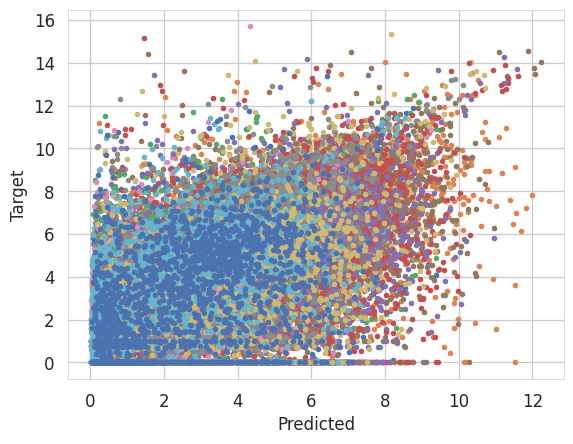

In [33]:
import matplotlib.pyplot as plt
plt.plot(np.log2((all_outputs+1)), np.log2(all_targets+1), '.')
plt.xlabel('Predicted')
plt.ylabel('Target')

In [34]:
spearmanr = [
    scipy.stats.spearmanr(np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets[:, i] + 1))[0] for i in range(all_outputs.shape[1])
]
pearsonr =  [
    scipy.stats.pearsonr (np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets[:, i] + 1))[0] for i in range(all_outputs.shape[1])]

In [35]:
np.mean(pearsonr), np.median(pearsonr) # np.mean(pearsonr), np.median(pearsonr) with normos (0.8695861071966647, 0.8775566542956221)

(np.float32(0.6490766), np.float32(0.6472279))

Text(0.5, 1.0, 'Count, across gene comparison')

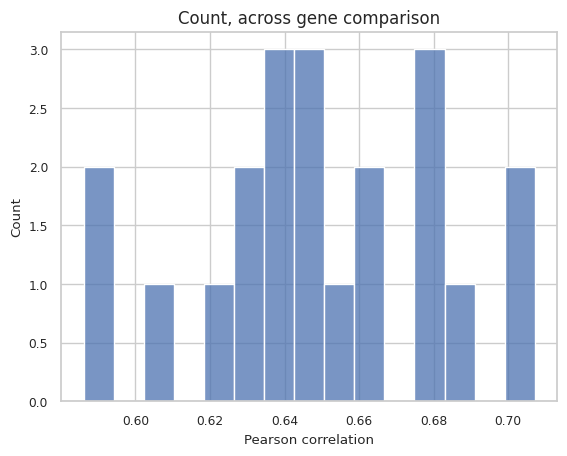

In [36]:
import seaborn as sns
sns.set_theme(style="whitegrid",  font_scale=0.8)
sns.histplot(pearsonr, bins = 15)
plt.xlabel('Pearson correlation')
plt.title('Count, across gene comparison',  size = 12)

In [37]:
# log2(x+1)
counts_predicted_log = np.log2(pd.DataFrame(all_outputs) + 1)  #pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_predicted_log.parquet")# np.log2(pd.DataFrame(all_outputs) + 1) 
#counts_predicted_log = counts_predicted_log.drop(16, axis = 1) #remove other myloids?
# substract mean per gene across all cell types
counts_predicted_log = counts_predicted_log - counts_predicted_log.mean(axis=0)

#substract mean per cell type across all genes
counts_predicted_log = counts_predicted_log.subtract(counts_predicted_log.mean(axis=1), axis=0)
counts_target_log =np.log2(pd.DataFrame(all_targets) + 1)# pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_target_log.parquet")# np.log2(pd.DataFrame(all_targets) + 1)
#counts_target_log = counts_target_log.drop(16, axis = 1) #remove other myloids?
counts_target_log = counts_target_log - counts_target_log.mean(axis=0)

counts_target_log = counts_target_log.subtract(counts_target_log.mean(axis=1), axis=0)

In [38]:
import matplotlib as mp
font_size=  12
mp.rcParams['axes.labelsize'] = font_size
mp.rcParams['axes.linewidth'] = font_size / 24.
mp.rcParams['axes.titlesize'] = font_size
mp.rcParams['legend.fontsize'] = font_size
mp.rcParams['xtick.labelsize'] = font_size
mp.rcParams['ytick.labelsize'] = font_size

0.42529818


Text(0.5, 0, 'Predicted')

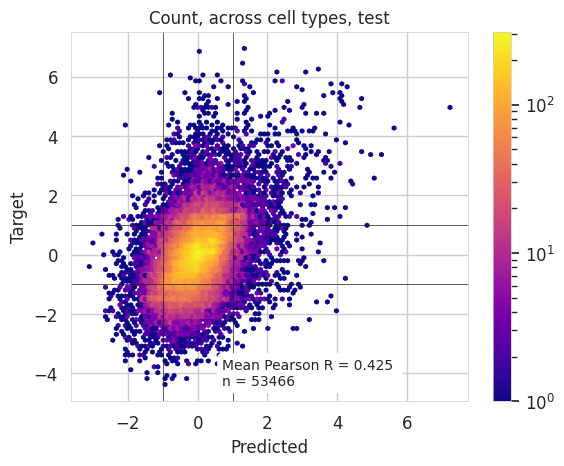

In [39]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
ax = plt.hexbin(x=counts_predicted_log.values.ravel(), y=counts_target_log.values.ravel(), mincnt=1, cmap='plasma', norm=LogNorm())
plt.axvline(1, c='k', linewidth = font_size/24)
plt.axvline(-1,c='k', linewidth = font_size/24)
plt.axhline(1,c='k', linewidth = font_size/24)
plt.axhline(-1,c='k', linewidth = font_size/24)
plt.colorbar()
plt.ylabel('Target')
plt.title('Count, across cell types, test')
p=scipy.stats.pearsonr(counts_predicted_log.values.ravel(), counts_target_log.values.ravel())[0]
# plt.text(2.5,-5, f"Pearson corr.: {np.round(p, 3)}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
plt.text(.7,-4.4, f"Mean " + r"Pearson R"+ f" = {p:.3f} \nn = {len(counts_predicted_log.values.ravel())}", bbox=dict(facecolor='white', edgecolor='white', boxstyle='round'), fontdict={'size' : 10})
print(p)
plt.xlabel('Predicted')
#plt.savefig("Fig2E.svg",bbox_inches="tight")

In [26]:
import scanpy as sc
import polars as pl
filter_val = lambda df: df.filter((pl.col('column_4') == f'fold3') )
val_ds = GenomeIntervalDataset(
        bed_file = "/s/project/QNA/borzoi_training_data/hg38/sequences.bed",#  os.path.join(data_path,'borzoi_training_data', 'val_gene_sequences.csv'), #"
        fasta_file = fasta_file,                        
        filter_df_fn = filter_val,#lambda df: df.filter((pl.col('column_2') >=0)),                       
        return_seq_indices = False,                         
        shift_augs = (0,0),                              
        rc_aug = False,
        return_augs = True,
        context_length = 524288,
        chr_bed_to_fasta_map = {}
    )

In [33]:
base_path

'/s/project/QNA/scborzoi/submission_data/snapatac/pseudobulks_fixed/'

In [36]:
from scooby.data.scdata import onTheFlyExonMultiomePseudobulkDataset 
val_dataset = onTheFlyExonMultiomePseudobulkDataset(
    cell_types = cell_type_index['celltype'],
    ds = val_ds, 
    base_path = '/s/project/QNA/scborzoi/submission_data/scooby_training_data/pseudobulks',
    seqlevelstyle="UCSC",
    clip_soft=5
)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 4)
csb, val_loader = accelerator.prepare(csb, val_loader)
#val_loader =  DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 6)

In [37]:
# cell_type_index contains index of cells that belong to one cell type
# cell_indices contains the embeddings of all cells belonging to a cell type

csb.eval()
cell_indices  = []
for _, row in tqdm.tqdm(cell_type_index.iterrows(),disable = True):
    #print (row)
    cell_indices.append(
        torch.from_numpy(
            np.vstack(
                embedding.iloc[row['cellindex']]['embedding'].values # gets embeddings of all cells of the cell type
                )
            ).unsqueeze(0)
        ) # prep cell_embeddings

# get conv weights and biases for all cells sorted by cell type in a list
cell_emb_conv_weights_and_biases =[]
for cell_emb_idx in tqdm.tqdm(cell_indices, disable = False):
    cell_emb_idx = cell_emb_idx.cuda()
    conv_weights, conv_biases = csb.forward_cell_embs_only(cell_emb_idx)
    cell_emb_conv_weights_and_biases.append((conv_weights, conv_biases))



00%|██████████| 21/21 [00:00<00:00, 381.12it/s]

In [ ]:
all_outputs_rna, all_outputs_atac, all_targets_rna, all_targets_atac = [], [], [], []

# iterate over all val gene sequences
for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):    
    bs = x[0].shape[0]
    assert bs == 1
    seqs = x[0].cuda().permute(0,2,1)
    seqs_rev_comp =  torch.flip(seqs.permute(0,2,1), (-1, -2)).permute(0,2,1)
    stacked_outputs,stacked_outputs_atac = [], []
    targets= x[2].cuda()

    # go over embeddings for all cells of a cell type, sum the unsquashed predictions
    for conv_weight, conv_bias in cell_emb_conv_weights_and_biases:
        # get predictions for all cells of one cell type
        outputs = predict(csb, seqs, seqs_rev_comp, conv_weight, conv_bias)
        # get RNA:
        outputs_rna = outputs[:,:,torch.tensor([1,1,0]).repeat(outputs.shape[2]//3).bool()]
        outputs_rna = outputs_rna.float().detach()
        unsquashed = undo_squashed_scale(outputs_rna[:, : ,:], clip_soft=5)
        
        # get ATAC:
        outputs_atac = outputs[:,:,torch.tensor([0,0,1]).repeat(outputs.shape[2]//3).bool()]
        outputs_atac = outputs_atac.float().detach()

        # we do *0.01 because we always predict 100 neighbors
        # sum exons on positive/negative strand for all cells
        num_pos = outputs.shape[-1]

        stacked_outputs.append(unsquashed[0, :,:num_pos:2].sum(-1)) #RNA
        stacked_outputs.append(unsquashed[0, :,1:num_pos:2].sum(-1)) #RNA
        stacked_outputs_atac.append(outputs_atac[0].sum(-1) * 20) # ATAC
        
    targets_rna = targets[:,:,torch.tensor([1,1,0]).repeat(targets.shape[2]//3).bool()]
    targets_rna = undo_squashed_scale(targets_rna.float().detach(), clip_soft = 5)

    # get ATAC:
    targets_atac = targets[:,:,torch.tensor([0,0,1]).repeat(targets.shape[2]//3).bool()]
    targets_atac = targets_atac.float().detach()

    #all_outputs_rna.append(torch.stack(stacked_outputs, dim = 0).detach())
    #all_outputs_atac.append(torch.stack(stacked_outputs_atac, dim = 0).detach())
    #all_targets_rna.append(targets_rna[0].detach().permute(1,0))
    #all_targets_atac.append(targets_atac[0].detach().permute(1,0))
    torch.save(torch.stack(stacked_outputs, dim = 0).detach(), f'/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval_fixed/profiles/test_seq_rna_{i}_pseudobulked.output')
    torch.save(torch.stack(stacked_outputs_atac, dim = 0).detach(), f'/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval_fixed/profiles/test_seq_atac_{i}_pseudobulked.output')
    torch.save(targets_rna[0].detach().permute(1,0), f'/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval_fixed/profiles/test_seq_rna_{i}_pseudobulked.target')
    torch.save(targets_atac[0].detach().permute(1,0), f'/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval_fixed/profiles/test_seq_atac_{i}_pseudobulked.target')
    
    #break
    #break
    #continue
    #torch.save(torch.stack(stacked_outputs, dim = 0).detach().cpu(), f'/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/profiles/val_gene_{i}_no_neighbors.output')
    #torch.save(targets[0].float().detach().permute(1,0).cpu(),f'/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/profiles/val_gene_{i}_no_neighbors.target')
    #if i == 20:
    #    break
    #targets = (next(val_dataset_target_loader)[2]).float().cuda()
    #if strand == '+':
    #    all_targets.append(undo_squashed_scale(targets[0, gene_slice, :num_pos:2], clip_soft=25).sum(axis=0).detach().clone().cpu())
    #elif strand == '-':
    #    all_targets.append(undo_squashed_scale(targets[0, gene_slice, 1:num_pos:2], clip_soft=25).sum(axis=0).detach().clone().cpu())
    
    



  1%|          | 69/6888 [01:00<1:19:58,  1.42it/s]